In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, numpy as np, pandas as pd, random
import matplotlib.pyplot as plt, seaborn as sns
import matplotlib.image as mpimg

from skimage.io import imread
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import label

from sklearn.model_selection import train_test_split
import tensorflow as tf
from PIL import Image, ImageDraw, ImageEnhance
from imutils import paths
import cv2
import albumentations as albu
from tqdm.notebook import tqdm

from ultralytics import YOLO
import squarify

sns.set_style('darkgrid')

%matplotlib inline
import gc
gc.enable

<function gc.enable()>

In [2]:
df=pd.read_csv('cleaned_ship_data.csv')
df

,Unnamed: 0,filename,width,height,class,xmin,xmax,ymin,ymax,image,image_path,image_file
0,0,201806260750_003,38,24,Boat,482,520,315,339,201806260750_003.png,C:/Users/DELL/Desktop/ship detectioon/Vessel D...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1,1,201806260750_004,30,32,Boat,447,477,353,385,201806260750_004.png,C:/Users/DELL/Desktop/ship detectioon/Vessel D...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
2,2,201806260750_004,6,7,Motorboat,785,791,269,276,201806260750_004.png,C:/Users/DELL/Desktop/ship detectioon/Vessel D...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
3,3,201806260750_007,9,3,Boat,596,605,277,280,201806260750_007.png,C:/Users/DELL/Desktop/ship detectioon/Vessel D...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
4,4,201806260750_007,11,11,Miscboat,980,991,269,280,201806260750_007.png,C:/Users/DELL/Desktop/ship detectioon/Vessel D...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
...,...,...,...,...,...,...,...,...,...,...,...,...
41962,41962,201807081615_062,5,10,Boat,929,934,252,262,201807081615_062.png,C:/Users/DELL/Desktop/ship detectioon/Vessel D...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
41963,41963,201807081615_063,40,21,Motorboat,301,341,264,285,201807081615_063.png,C:/Users/DELL/Desktop/ship detectioon/Vessel D...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
41964,41964,201807081615_063,44,23,Boat,60,104,284,307,201807081615_063.png,C:/Users/DELL/Desktop/ship detectioon/Vessel D...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
41965,41965,201807081615_063,15,55,Seamark,928,943,251,306,201807081615_063.png,C:/Users/DELL/Desktop/ship detectioon/Vessel D...,<PIL.PngImagePlugin.PngImageFile image mode=RG...


In [3]:
sublist=[]
for i in range(len(df)):
    sublist.append([df['xmin'][i],df['ymin'][i], df['width'][i], df['height'][i]])
    
df['bbox'] =sublist

In [4]:
df

,Unnamed: 0,filename,width,height,class,xmin,xmax,ymin,ymax,image,image_path,image_file,bbox
0,0,201806260750_003,38,24,Boat,482,520,315,339,201806260750_003.png,C:/Users/DELL/Desktop/ship detectioon/Vessel D...,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[482, 315, 38, 24]"
1,1,201806260750_004,30,32,Boat,447,477,353,385,201806260750_004.png,C:/Users/DELL/Desktop/ship detectioon/Vessel D...,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[447, 353, 30, 32]"
2,2,201806260750_004,6,7,Motorboat,785,791,269,276,201806260750_004.png,C:/Users/DELL/Desktop/ship detectioon/Vessel D...,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[785, 269, 6, 7]"
3,3,201806260750_007,9,3,Boat,596,605,277,280,201806260750_007.png,C:/Users/DELL/Desktop/ship detectioon/Vessel D...,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[596, 277, 9, 3]"
4,4,201806260750_007,11,11,Miscboat,980,991,269,280,201806260750_007.png,C:/Users/DELL/Desktop/ship detectioon/Vessel D...,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[980, 269, 11, 11]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41962,41962,201807081615_062,5,10,Boat,929,934,252,262,201807081615_062.png,C:/Users/DELL/Desktop/ship detectioon/Vessel D...,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[929, 252, 5, 10]"
41963,41963,201807081615_063,40,21,Motorboat,301,341,264,285,201807081615_063.png,C:/Users/DELL/Desktop/ship detectioon/Vessel D...,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[301, 264, 40, 21]"
41964,41964,201807081615_063,44,23,Boat,60,104,284,307,201807081615_063.png,C:/Users/DELL/Desktop/ship detectioon/Vessel D...,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[60, 284, 44, 23]"
41965,41965,201807081615_063,15,55,Seamark,928,943,251,306,201807081615_063.png,C:/Users/DELL/Desktop/ship detectioon/Vessel D...,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[928, 251, 15, 55]"


In [5]:
df['bbox']

0         [482, 315, 38, 24]
1         [447, 353, 30, 32]
2           [785, 269, 6, 7]
3           [596, 277, 9, 3]
4         [980, 269, 11, 11]
                ...         
41962      [929, 252, 5, 10]
41963     [301, 264, 40, 21]
41964      [60, 284, 44, 23]
41965     [928, 251, 15, 55]
41966    [1168, 290, 26, 23]
Name: bbox, Length: 41967, dtype: object

#### Visualization of images without labels

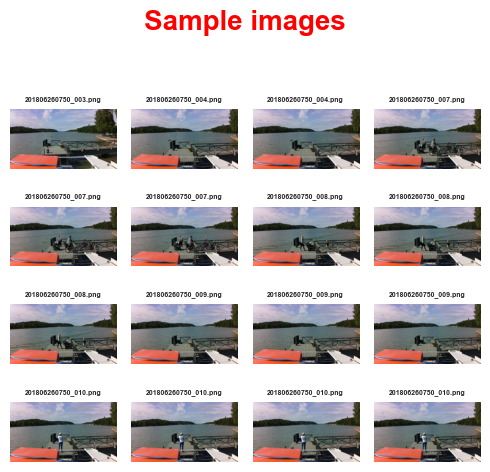

In [6]:
plt.figure(figsize=(5,5))
plt.suptitle('Sample images\n', weight = 'bold', fontsize = 20, color = 'r')
for i in range(16):
    plt.subplot(4,4, i+1)
    plt.imshow(imread(df['image_path'][i]))
    plt.title(f"{df['image'][i]}", weight = 'bold', fontsize=5)
    plt.axis('off')
plt.tight_layout()

#### Visualization of Images with labels

In [7]:
root="C:/Users/DELL/Desktop/ship detectioon/Vessel Detection/ABOshipsDataset/Seaships"

image_path_list=list(paths.list_images(root))
image_path_list

['C:/Users/DELL/Desktop/ship detectioon/Vessel Detection/ABOshipsDataset/Seaships\\20180626\\201806260722_000.png',
 'C:/Users/DELL/Desktop/ship detectioon/Vessel Detection/ABOshipsDataset/Seaships\\20180626\\201806260722_001.png',
 'C:/Users/DELL/Desktop/ship detectioon/Vessel Detection/ABOshipsDataset/Seaships\\20180626\\201806260750_000.png',
 'C:/Users/DELL/Desktop/ship detectioon/Vessel Detection/ABOshipsDataset/Seaships\\20180626\\201806260750_001.png',
 'C:/Users/DELL/Desktop/ship detectioon/Vessel Detection/ABOshipsDataset/Seaships\\20180626\\201806260750_002.png',
 'C:/Users/DELL/Desktop/ship detectioon/Vessel Detection/ABOshipsDataset/Seaships\\20180626\\201806260750_003.png',
 'C:/Users/DELL/Desktop/ship detectioon/Vessel Detection/ABOshipsDataset/Seaships\\20180626\\201806260750_004.png',
 'C:/Users/DELL/Desktop/ship detectioon/Vessel Detection/ABOshipsDataset/Seaships\\20180626\\201806260750_005.png',
 'C:/Users/DELL/Desktop/ship detectioon/Vessel Detection/ABOshipsDataset

In [8]:
labels=df[['filename', 'width', 'height', 'bbox', 'image_path']]
labels

,filename,width,height,bbox,image_path
0,201806260750_003,38,24,"[482, 315, 38, 24]",C:/Users/DELL/Desktop/ship detectioon/Vessel D...
1,201806260750_004,30,32,"[447, 353, 30, 32]",C:/Users/DELL/Desktop/ship detectioon/Vessel D...
2,201806260750_004,6,7,"[785, 269, 6, 7]",C:/Users/DELL/Desktop/ship detectioon/Vessel D...
3,201806260750_007,9,3,"[596, 277, 9, 3]",C:/Users/DELL/Desktop/ship detectioon/Vessel D...
4,201806260750_007,11,11,"[980, 269, 11, 11]",C:/Users/DELL/Desktop/ship detectioon/Vessel D...
...,...,...,...,...,...
41962,201807081615_062,5,10,"[929, 252, 5, 10]",C:/Users/DELL/Desktop/ship detectioon/Vessel D...
41963,201807081615_063,40,21,"[301, 264, 40, 21]",C:/Users/DELL/Desktop/ship detectioon/Vessel D...
41964,201807081615_063,44,23,"[60, 284, 44, 23]",C:/Users/DELL/Desktop/ship detectioon/Vessel D...
41965,201807081615_063,15,55,"[928, 251, 15, 55]",C:/Users/DELL/Desktop/ship detectioon/Vessel D...


In [9]:
def group_boxes(group):
    boundaries = str(group['bbox']).split(',')
    return boundaries

labels = labels.groupby('filename').apply(group_boxes)

In [10]:
labels['201807081615_062'][0:5]

['41949     [500', ' 253', ' 48', ' 27]\n41950     [1018', ' 252']

In [11]:
len(labels)

9041

In [12]:
train_image_ids = np.unique(labels.index.values)[0:7233]
val_image_ids = np.unique(labels.index.values)[7233:9041]

In [13]:
train_image_ids

array(['201806260750_001', '201806260750_003', '201806260750_004', ..., '201807061450_013', '201807061450_014', '201807061450_015'], dtype=object)

In [14]:
val_image_ids

array(['201807061450_016', '201807061450_017', '201807061450_018', ..., '201807081615_061', '201807081615_062', '201807081615_063'], dtype=object)

In [15]:
def load_image(image_id):
    image = Image.open(image_path_list[image_id])
    image = image.resize((256, 256))
    return np.asarray(image)

In [16]:
train_pixels = {}
train_labels = {}

for image_id in tqdm(range(len(train_image_ids))):
    train_pixels[image_id] = load_image(image_id)
    train_labels[image_id] = labels[image_id].copy()

  0%|          | 0/7233 [00:00<?, ?it/s]

In [17]:
val_pixels = {}
val_labels = {}

for image_id in tqdm(range(len(val_image_ids))):
    val_pixels[image_id] = load_image(image_id)
    val_labels[image_id] = labels[image_id].copy()

  0%|          | 0/1808 [00:00<?, ?it/s]

In [18]:
val_pixels

{0: array([[[179, 183, 222],
         [178, 182, 221],
         [179, 183, 222],
         ...,
         [179, 168, 194],
         [178, 169, 195],
         [178, 171, 196]],
 
        [[179, 182, 224],
         [178, 181, 223],
         [178, 181, 223],
         ...,
         [175, 166, 194],
         [174, 167, 194],
         [175, 169, 195]],
 
        [[179, 182, 225],
         [177, 180, 223],
         [174, 177, 221],
         ...,
         [172, 164, 194],
         [171, 165, 194],
         [172, 167, 194]],
 
        ...,
 
        [[251, 103,  68],
         [249, 102,  68],
         [249, 101,  65],
         ...,
         [156, 141, 130],
         [121, 101,  93],
         [170, 155, 147]],
 
        [[252, 103,  67],
         [251, 102,  66],
         [250, 101,  65],
         ...,
         [183, 167, 155],
         [143, 124, 115],
         [ 88,  71,  64]],
 
        [[254, 103,  68],
         [253, 102,  67],
         [252, 101,  66],
         ...,
         [197, 180, 174],

In [19]:
"""def draw_bboxes(image_path, bboxes):  
    image = Image.open(image_list[image_path])
    image = image.resize((256,256))
    
    draw = ImageDraw.Draw(image)
            
    for bbox in bboxes:
        draw_bbox(draw, bbox)
    
    return np.asarray(image)


def draw_bbox(draw, bbox):
    x, y, width, height = bbox
    draw.rectangle([x, y, x + width, y + height], width=2, outline='red')"""

"def draw_bboxes(image_path, bboxes):  \n    image = Image.open(image_list[image_path])\n    image = image.resize((256,256))\n    \n    draw = ImageDraw.Draw(image)\n            \n    for bbox in bboxes:\n        draw_bbox(draw, bbox)\n    \n    return np.asarray(image)\n\n\ndef draw_bbox(draw, bbox):\n    x, y, width, height = bbox\n    draw.rectangle([x, y, x + width, y + height], width=2, outline='red')"

In [20]:
"""def show_images(images, bboxes, source='train'):
    pixels = []
    root='C:/Users/DELL/Desktop/ship detectioon/Vessel Detection/ABOshipsDataset/Seaships\\20180626\\'
    for image in images:
        image=root+image+'.png'
        pixels.append(
            draw_bboxes( image, bboxes[image],)
        )
    
    num_of_images = len(images)
    fig, axes = plt.subplots(
        1, 
        num_of_images, 
        figsize=(5 * num_of_images, 5 * num_of_images)
    )
    
    for i, image_pixels in enumerate(pixels):
        axes[i].imshow(image_pixels)"""

"def show_images(images, bboxes, source='train'):\n    pixels = []\n    root='C:/Users/DELL/Desktop/ship detectioon/Vessel Detection/ABOshipsDataset/Seaships\\20180626\\'\n    for image in images:\n        image=root+image+'.png'\n        pixels.append(\n            draw_bboxes( image, bboxes[image],)\n        )\n    \n    num_of_images = len(images)\n    fig, axes = plt.subplots(\n        1, \n        num_of_images, \n        figsize=(5 * num_of_images, 5 * num_of_images)\n    )\n    \n    for i, image_pixels in enumerate(pixels):\n        axes[i].imshow(image_pixels)"

In [21]:
"""show_images(train_image_ids[0:4], train_labels)"""

'show_images(train_image_ids[0:4], train_labels)'

# Data Pipeline

Usually I would use Tensorflows data api or keras data generators to build a pipeline to get data into the model. However the pre-processing that needs to be done for this model is not trivial and it turned out to be easier to create a custom data generator. This takes the form of a class that is passed to keras' fit generator function. It contains the following functionality:

- define the size of the dataset. Keras needs this to work out how long an epoch is.
- shuffle the dataset.
- get an image and augment it to add variety to the dataset. This includes amending bounding boxes when a head of wheat has changed in the image.
- reshape the bounding boxes to a label grid.

I'll start by initialising the class.

**I will also try to use tensorflow after this**

In [40]:
class DataGenerator(tf.keras.Sequential):
    def __init__(self, filename, image_pixels, labels=None, batch_size=1, shuffle=False, augment=False):
        self.filename=filename
        self.image_pixels=image_pixels
        self.labels=labels
        self.batch_size=batch_size
        self.shuffle=shuffle
        self.augment=augment
        self.on_epoch_end()
        self.image_grid=self.form_image_grid()
        
    def form_image_grid(self):
        image_grid=np.zeros((32,32,4))
        #x, y, width, height
        cell=[0,0,256/32, 256/32]
        
        for i in range(0, 32):
            for j in range(0,32):
                image_grid[i,j]=cell
                cell[0]=cell[0]+cell[2]
            cell[0]=0
            cell[1]=cell[1]+cell[3]
        return image_grid

Next I will add some methods to the class that keras needs to operate the data generation. length is used to determine how many images there are in the dataset. on_epoch_end is called at the end of each epoch (as well once before training starts) to get the index of all images in the dataset. It is also has the opportunity to shuffle the dataset per epoch if the generator was configured to do so.

In [41]:
def __len__(self):
    return int(np.floor(len(self.filename)/self.batch_size))

def on_epoch_end(self):
    self.indexes = np.arange(len(self.filename))
    if self.shuffle ==True:
        np.random.shuffle(self.indexes)

DataGenerator.__len__ = __len__
DataGenerator.on_epoch_end = on_epoch_end

Regarding the augmentations a number of transformations will be applied to each training image before they are fed into the model. This helps to add some diversity to a small dataset effectively growing it to a much larger one:

- random sized crop: The model needs to be able to detect a wheat head regardless of how close or far away the head is to the camera. To produce more zoom levels in the dataset the crop method will take a portion of the image and zoom in to create a new image with larger wheat heads.

- flip amd rotate: The wheat heads can point in any direction. To create more examples of wheat heads pointing in different directions the image will randomly be flipped both horizontally and vertically or rotated.

- hue saturation and brightness: these are various methods that will alter the lighting of the image which will help to create different lighting scenarios. This helps as the test pictures are from various countries each with their own lighting levels.

- noise: Some wheat heads aren't quite in focus. Adding some noise to the images helps to catch these wheat heads while also forcing the model to learn more abstract wheat head shapes. This helps a lot with over-fitting.

- cutout: randomly remove small squares of pixels in the image. This prevents the model simply memorizing certain wheat heads and instead forces it to learn the patterns that represent a wheat head.

- clahe: this is a must have. In many images the wheat heads are a similar colour to the grass in the background making it tricky for the model to differentiate between them. CLAHE helps to exemplify the colour difference between the two.

- grey scale: I found that there were a few images with a yellow/gold tint. My model was learning to detect wheat heads without a tint (as most images do not contain a tint) and was really struggling to detect anything on the yellow images. By converting all images to grey scale the model is forced to ignore these tints making it much more effective at identifying wheat heads regardless of tint.
I also greyscale and apply CLAHE to each validation image as the model has learnt on grey images where the wheat heads are given a lighter shade of grey.

In [42]:
DataGenerator.train_augmentations = albu.Compose([
        albu.RandomSizedCrop(
            min_max_height=(200, 200), 
            height=256, 
            width=256, 
            p=0.8
        ),
        albu.OneOf([
            albu.Flip(),
            albu.RandomRotate90(),
        ], p=1),
        albu.OneOf([
            albu.HueSaturationValue(),
            albu.RandomBrightnessContrast()
        ], p=1),
        albu.OneOf([
            albu.GaussNoise(),
            albu.GlassBlur(),
            albu.ISONoise(),
            albu.MultiplicativeNoise(),
        ], p=0.5),
        albu.Cutout(
            num_holes=8, 
            max_h_size=16, 
            max_w_size=16, 
            fill_value=0, 
            p=0.5
        ),
        albu.CLAHE(p=1),
        albu.ToGray(p=1),
    ], 
    bbox_params={'format': 'coco', 'label_fields': ['labels']})

DataGenerator.val_augmentations = albu.Compose([
    albu.CLAHE(p=1),
    albu.ToGray(p=1),
])


In [43]:
def __getitem__(self, index):
    indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

    batch_ids = [self.image_ids[i] for i in indexes]

    X, y = self.__data_generation(batch_ids)

    return X, y


def __data_generation(self, batch_ids):
    X, y = [], []

    # Generate data
    for i, image_id in enumerate(batch_ids):
        pixels = self.image_pixels[image_id]
        bboxes = self.labels[image_id]

        if self.augment:     
            pixels, bboxes = self.augment_image(pixels, bboxes)
        else:
            pixels = self.contrast_image(pixels)
            bboxes = self.form_label_grid(bboxes)

        X.append(pixels)
        y.append(bboxes)

    return np.array(X), np.array(y)


def augment_image(self, pixels, bboxes):
    bbox_labels = np.ones(len(bboxes))

    aug_result = self.train_augmentations(image=pixels, bboxes=bboxes, labels=bbox_labels)

    bboxes = self.form_label_grid(aug_result['bboxes'])

    return np.array(aug_result['image']) / 255, bboxes


def contrast_image(self, pixels):        
    aug_result = self.val_augmentations(image=pixels)
    return np.array(aug_result['image']) / 255


DataGenerator.__getitem__ = __getitem__
DataGenerator.__data_generation = __data_generation
DataGenerator.augment_image = augment_image
DataGenerator.contrast_image = contrast_image

In [44]:
def form_label_grid(self, bboxes):
    label_grid = np.zeros((32, 32, 10))

    for i in range(0, 32):
        for j in range(0, 32):
            cell = self.image_grid[i,j]
            label_grid[i,j] = self.rect_intersect(cell, bboxes)

    return label_grid


def rect_intersect(self, cell, bboxes): 
    cell_x, cell_y, cell_width, cell_height = cell
    cell_x_max = cell_x + cell_width 
    cell_y_max = cell_y + cell_height
    
    anchor_one = np.array([0, 0, 0, 0, 0])
    anchor_two = np.array([0, 0, 0, 0, 0])

    # check all boxes
    for bbox in bboxes:
        box_x, box_y, box_width, box_height = bbox
        box_x_centre = box_x + (box_width / 2)
        box_y_centre = box_y + (box_height / 2)

        if(box_x_centre >= cell_x and box_x_centre < cell_x_max and box_y_centre >= cell_y and box_y_centre < cell_y_max):
            
            if anchor_one[0] == 0:
                anchor_one = self.yolo_shape(
                    [box_x, box_y, box_width, box_height], 
                    [cell_x, cell_y, cell_width, cell_height]
                )
            
            elif anchor_two[0] == 0:
                anchor_two = self.yolo_shape(
                    [box_x, box_y, box_width, box_height], 
                    [cell_x, cell_y, cell_width, cell_height]
                )
                
            else:
                break

    return np.concatenate((anchor_one, anchor_two), axis=None)


def yolo_shape(self, box, cell):
    box_x, box_y, box_width, box_height = box
    cell_x, cell_y, cell_width, cell_height = cell

    # top left x,y to centre x,y
    box_x = box_x + (box_width / 2)
    box_y = box_y + (box_height / 2)

    # offset bbox x,y to cell x,y
    box_x = (box_x - cell_x) / cell_width
    box_y = (box_y - cell_y) / cell_height

    # bbox width,height relative to cell width,height
    box_width = box_width / 256
    box_height = box_height / 256

    return [1, box_x, box_y, box_width, box_height]


DataGenerator.form_label_grid = form_label_grid
DataGenerator.rect_intersect = rect_intersect
DataGenerator.yolo_shape = yolo_shape

In [46]:
train_generator = DataGenerator(
    train_image_ids,
    train_pixels,
    train_labels, 
    batch_size=6, 
    shuffle=True,
    augment=True
)

val_generator = DataGenerator(
    val_image_ids, 
    val_pixels,
    val_labels, 
    batch_size=10,
    shuffle=False,
    augment=False
)

image_grid = train_generator.image_grid

In [47]:
x_input = tf.keras.Input(shape=(256,256,3))

x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

########## block 1 ##########
x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x


########## block 2 ##########
x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## block 3 ##########
x = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

    
########## block 4 ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## block 5 ##########
x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(4):
    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## output layers ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

predictions = tf.keras.layers.Conv2D(10, (1, 1), strides=(1, 1), activation='sigmoid')(x)

model = tf.keras.Model(inputs=x_input, outputs=predictions)

In [48]:
def custom_loss(y_true, y_pred):
    binary_crossentropy = prob_loss = tf.keras.losses.BinaryCrossentropy(
        reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
    )
    
    prob_loss = binary_crossentropy(
        tf.concat([y_true[:,:,:,0], y_true[:,:,:,5]], axis=0), 
        tf.concat([y_pred[:,:,:,0], y_pred[:,:,:,5]], axis=0)
    )
    
    xy_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,1:3], y_true[:,:,:,6:8]], axis=0), 
        tf.concat([y_pred[:,:,:,1:3], y_pred[:,:,:,6:8]], axis=0)
    )
    
    wh_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,3:5], y_true[:,:,:,8:10]], axis=0), 
        tf.concat([y_pred[:,:,:,3:5], y_pred[:,:,:,8:10]], axis=0)
    )
    
    bboxes_mask = get_mask(y_true)
    
    xy_loss = xy_loss * bboxes_mask
    wh_loss = wh_loss * bboxes_mask
    
    return prob_loss + xy_loss + wh_loss


def get_mask(y_true):
    anchor_one_mask = tf.where(
        y_true[:,:,:,0] == 0, 
        0.5, 
        5.0
    )
    
    anchor_two_mask = tf.where(
        y_true[:,:,:,5] == 0, 
        0.5, 
        5.0
    )
    
    bboxes_mask = tf.concat(
        [anchor_one_mask,anchor_two_mask],
        axis=0
    )
    
    return bboxes_mask

In [49]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimiser, 
    loss=custom_loss
)

In [50]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True),
]

In [51]:
history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    epochs=80,
    callbacks=callbacks
)

ValueError: Failed to find data adapter that can handle input: <class '__main__.DataGenerator'>, <class 'NoneType'>

In [ ]:
def prediction_to_bbox(bboxes, image_grid):    
    bboxes = bboxes.copy()
    
    im_width = (image_grid[:,:,2] * 32)
    im_height = (image_grid[:,:,3] * 32)
    
    # descale x,y
    bboxes[:,:,1] = (bboxes[:,:,1] * image_grid[:,:,2]) + image_grid[:,:,0]
    bboxes[:,:,2] = (bboxes[:,:,2] * image_grid[:,:,3]) + image_grid[:,:,1]
    bboxes[:,:,6] = (bboxes[:,:,6] * image_grid[:,:,2]) + image_grid[:,:,0]
    bboxes[:,:,7] = (bboxes[:,:,7] * image_grid[:,:,3]) + image_grid[:,:,1]
    
    # descale width,height
    bboxes[:,:,3] = bboxes[:,:,3] * im_width 
    bboxes[:,:,4] = bboxes[:,:,4] * im_height
    bboxes[:,:,8] = bboxes[:,:,8] * im_width 
    bboxes[:,:,9] = bboxes[:,:,9] * im_height
    
    # centre x,y to top left x,y
    bboxes[:,:,1] = bboxes[:,:,1] - (bboxes[:,:,3] / 2)
    bboxes[:,:,2] = bboxes[:,:,2] - (bboxes[:,:,4] / 2)
    bboxes[:,:,6] = bboxes[:,:,6] - (bboxes[:,:,8] / 2)
    bboxes[:,:,7] = bboxes[:,:,7] - (bboxes[:,:,9] / 2)
    
    # width,heigth to x_max,y_max
    bboxes[:,:,3] = bboxes[:,:,1] + bboxes[:,:,3]
    bboxes[:,:,4] = bboxes[:,:,2] + bboxes[:,:,4]
    bboxes[:,:,8] = bboxes[:,:,6] + bboxes[:,:,8]
    bboxes[:,:,9] = bboxes[:,:,7] + bboxes[:,:,9]
    
    return bboxes

In [ ]:
def non_max_suppression(predictions, top_n):
    probabilities = np.concatenate((predictions[:,:,0].flatten(), predictions[:,:,5].flatten()), axis=None)
    
    first_anchors = predictions[:,:,1:5].reshape((32*32, 4))
    second_anchors = predictions[:,:,6:10].reshape((32*32, 4))
    
    bboxes = np.concatenate(
        (first_anchors,second_anchors),
        axis=0
    )
    
    bboxes = switch_x_y(bboxes)
    bboxes, probabilities = select_top(probabilities, bboxes, top_n=top_n)
    bboxes = switch_x_y(bboxes)
    
    return bboxes


def switch_x_y(bboxes):
    x1 = bboxes[:,0].copy()
    y1 = bboxes[:,1].copy()
    x2 = bboxes[:,2].copy()
    y2 = bboxes[:,3].copy()
    
    bboxes[:,0] = y1
    bboxes[:,1] = x1
    bboxes[:,2] = y2
    bboxes[:,3] = x2
    
    return bboxes


def select_top(probabilities, boxes, top_n=10):
    top_indices = tf.image.non_max_suppression(
        boxes = boxes, 
        scores = probabilities, 
        max_output_size = top_n, 
        iou_threshold = 0.3,
        score_threshold = 0.3
    )
    
    top_indices = top_indices.numpy()
    
    return boxes[top_indices], probabilities[top_indices]

In [ ]:
def process_predictions(predictions, image_ids, image_grid):
    bboxes = {}
    
    for i, image_id in enumerate(image_ids):
        predictions[i] = prediction_to_bbox(predictions[i], image_grid)
        bboxes[image_id] = non_max_suppression(predictions[i], top_n=100)
        
        # back to coco shape
        bboxes[image_id][:,2:4] = bboxes[image_id][:,2:4] - bboxes[image_id][:,0:2]
    
    return bboxes

In [ ]:
val_predictions = model.predict(val_generator)
val_predictions = process_predictions(val_predictions, val_image_ids, image_grid)

In [ ]:
show_images(val_image_ids[0:4], val_predictions)

In [ ]:
show_images(val_image_ids[4:8], val_predictions)

In [ ]:
print('Epochs: ' + str(len(history.history['loss'])))
print('Final training loss: ' + str(history.history['loss'][-1]))
print('Final validation loss: ' + str(history.history['val_loss'][-1]))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Training Loss')
ax[0].plot(history.history['loss'])

ax[1].set_title('Validation Loss')
ax[1].plot(history.history['val_loss'])

In [ ]:
layer_outputs = [layer.output for layer in model.layers]
evaluation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
image = Image.open(train_image_ids[image_path][1] )
image = image.resize((256, 256))

pixels = np.asarray(image) / 255
pixels = np.expand_dims(pixels, axis=0)

In [ ]:
num_of_layers = len(layer_outputs)

fig, axes = plt.subplots(2, 6, figsize=(20, 10))

layer = 0
for i in range(0, 2):
    for j in range(0, 6):
        layer_output = evaluation_model.predict(pixels)[layer]
        axes[i, j].imshow(layer_output[0, :, :, 1], cmap='inferno')
        
        layer = layer + 1

In [ ]:
test_image_ids = os.listdir('/kaggle/input/global-wheat-detection/test/')
test_image_ids = [image_id[:-4] for image_id in test_image_ids]

In [ ]:
test_predictions = []

for i, image_id in enumerate(test_image_ids):
    image = Image.open('/kaggle/input/global-wheat-detection/test/' + image_id + ".jpg")
    image = image.resize((256, 256))            

    pixels = np.asarray(image)

    val_augmentations = albu.Compose([
        albu.CLAHE(p=1),
        albu.ToGray(p=1)
    ])

    aug_result = val_augmentations(image=pixels)
    pixels = np.array(aug_result['image']) / 255
    
    pixels = np.expand_dims(pixels, axis=0)
    
    bboxes = model.predict(pixels)

    test_predictions.append(bboxes)
    
test_predictions = np.concatenate(test_predictions)

In [ ]:
test_predictions = process_predictions(test_predictions, test_image_ids, image_grid)

In [ ]:
show_images(test_image_ids[0:4], test_predictions, source='test')

In [ ]:
show_images(test_image_ids[4:8], test_predictions, source='test')

In [ ]:
show_images(test_image_ids[8:10], test_predictions, source='test')

In [ ]:
model.save_weights('wheat_detection_model')